In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import vector
import math
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

In [3]:
class Particle: 
    def __init__(self,position = vector.obj(x=0,y=0,z=0),velocity = vector.obj(x=0,y=0,z=0),acceleration = vector.obj(x=0,y=0,z=0),mass = 6.63*10**-26):
        self.position = position
        self.velocity = velocity
        self.acceleration = acceleration


In [4]:
class Simulation:
    def __init__(self,length,initial_particle_state):
        self.max_displacement = length/2 #(m)
        self.min_displacement = -length/2 #(m)
        self.time_passed = 0 #(s)
        self.argon_mass = 6.63*10**-26 #(kg)
        self.instantaneous_del_momentum_x_positive = 0 #(kgm/s)
        self.totalDelMomentum_x_positive = 0 #(kgm/s)
        self.stateSnapshots = []
        self.temperatures = []
        self.pressures = []
        self.boltzmann_constant = 1.38*10**-23
        self.stateSnapshots.append(initial_particle_state)
        self.particles = initial_particle_state

   

    def update_acceleration(self):
        #Argon parameters
        sigma = 0.3345*10**-9 #m
        epsilon = 1.735*10**-21
        argon_mass = 6.63*10**-26 #kg
        for i in range(0,len(self.particles)):
            #Instantiatet the force vector acting upon i from all other possible particles j_n
            vec_force_i  = vector.obj(x=0.0,y=0.0,z=0.0)
            for j in range(0,len(self.particles)):
                if (i == j):
                    continue
                vec_position_i = self.particles[i].position
                vec_position_j = self.particles[j].position
                #Considering the position vector from particle j to i
                vec_distance_ji = vec_position_i - vec_position_j
                vec_direction_ji =  vec_distance_ji/(vec_distance_ji.mag)
                mag_distance_ji = vec_distance_ji.mag
                #Force eqn below from radial distance derivative of Lennard-Jones potential
                # if (mag_distance_ji != 0):
                mag_force = 24*epsilon*sigma**6*(mag_distance_ji**6-2*sigma**6)/(mag_distance_ji**13)
                # else:
                    # mag_force = 0
                vec_force_ji = mag_force*vec_direction_ji
                vec_force_i = vec_force_i + vec_force_ji
                # vec_force_i =  vec_force_ji

            #Finally we have spatial acceleration vector
            vec_acc_i = vec_force_i/argon_mass
            if (mag_distance_ji != 0):
                self.particles[i].acceleration = vec_acc_i
            else:
                self.particles[i].acceleration = vector.obj(x=0.0,y=0.0,z=0.0)
            
            # print('Positions Used to get this acceleration')
            # print(self.particles[i].acceleration)
            
        return self.particles

    def update_velocity(self,dt=0.00001):
        for i in range(0,len(self.particles)):
            # print('Which was used to get this velocity ')
            self.particles[i].velocity = self.particles[i].velocity + (dt/2)*self.particles[i].acceleration 
            # print(self.particles[i].velocity)

        return self.particles
            
    def update_position(self,dt=0.00001):
        self.instantaneous_del_momentum_x_positive = 0
        for i in range(0,len(self.particles)):
            # print('Prev vector Position')
            # print(self.particles[i].position)
            # print('Adding this vector')
            # print(dt*self.particles[i].velocity)
            # print('To get this new position')
            # print(self.particles[i].position + (dt)*self.particles[i].velocity)
            self.particles[i].position = self.particles[i].position + (dt)*self.particles[i].velocity
            
            # print('New position is')
            # print(self.particles[i].position.x)

            #In +ve x direction:
            if (self.particles[i].position.x > self.max_displacement): #if a particle has passed 'tried' to pass the boundary 
                # print('triggered')
                #Place the particle at the boundary
                self.particles[i].position.x = self.max_displacement
                #Increment the total del_momentum in x for future momentum calculation
                self.instantaneous_del_momentum_x_positive += self.argon_mass*self.particles[i].velocity.mag
                self.totalDelMomentum_x_positive += self.argon_mass*self.particles[i].velocity.mag
                #Reverse its momentum in relevant direction to simulate an elastic collision
                self.particles[i].velocity.x = -1*self.particles[i].velocity.x
            #in -ve x direction:
            elif(self.particles[i].position.x < self.min_displacement):
                #Place the particle at the boundary
                self.particles[i].position.x = self.min_displacement
                #We will not consider del momentum for any other directions, since principle of pressure symmetry should
                #allow us to calculate total pressure from total del momentum using one sign of one axis.
                self.particles[i].velocity.x = -1*self.particles[i].velocity.x
            #On y axis:
            if (self.particles[i].position.y > self.max_displacement): 
                self.particles[i].position.y = self.max_displacement
                self.particles[i].velocity.y = -1*self.particles[i].velocity.y
            elif(self.particles[i].position.y < self.min_displacement):
                self.particles[i].position.y = self.min_displacement
                self.particles[i].velocity.y = -1*self.particles[i].velocity.y
            #On z axis:
            if (self.particles[i].position.z > self.max_displacement): 
                self.particles[i].position.z = self.max_displacement
                self.particles[i].velocity.z = -1*self.particles[i].velocity.z
            elif(self.particles[i].position.z < self.min_displacement):
                self.particles[i].position.z = self.min_displacement
                self.particles[i].velocity.z = -1*self.particles[i].velocity.z
            # print("After adjusting for colliisons we have")
            # print(self.particles[i].position)

        return self.particles

    def capture_state(self):
        state = []
        for element in self.particles:
            tempParticle = Particle(position = element.position,velocity=element.velocity,acceleration=element.acceleration)
            state.append(tempParticle)
        return state

    def calculate_instantaneous_pressure(self,delt):
        face_area = (self.max_displacement*2)**2
        p_x_instantaneous = (1/(face_area*delt))*self.instantaneous_del_momentum_x_positive
        pressure_instantaneous = 3*p_x_instantaneous 
        self.pressures.append(pressure_instantaneous)
        return pressure_instantaneous

    def calculate_average_pressure(self,delt):
        face_area = (self.max_displacement*2)**2
        total_time = delt*len(self.stateSnapshots)
        p_x_average = (1/(face_area*total_time))*self.totalDelMomentum_x_positive
        presure_average = 3*p_x_average
        return presure_average

    def calculate_temperature(self):
        # Temperature related to total KE of a gas
        particle_state = self.capture_state()
        N_particles = len(particle_state)
        KE = 0
        for particle in particle_state:
            # Calculate magnitude velocity 
            vel_mag = math.sqrt(particle.velocity.x**2+particle.velocity.y**2+particle.velocity.z**2)
            KE+= 0.5*self.argon_mass*vel_mag
        temperature = KE*(0.666)/(N_particles*self.boltzmann_constant)
        self.temperatures.append(temperature)
        return temperature

    def main(self,delt = 0.00001,nSteps=100,maxTime=0,render = False):
        time=0
        self.times = [0]
        state_list = []
        state_list.append(self.capture_state())
        # print(self.particles[0].position.x)
        if (maxTime == 0):
            maxTime = nSteps*delt
        while (time <= maxTime):
            # print('accn A before')
            # print(self.particles[0].acceleration)
            particles = self.update_acceleration()
            # print('accn A after')
            # print(self.particles[0].acceleration)
            particles = self.update_velocity(dt = delt)
            # print('pos A before')
            # print(self.particles[0].position)
            particles = self.update_position(dt = delt)
            # print('pos A after')
            # print(self.particles[0].position)
            temperature = self.calculate_temperature()
            instant_pressure = self.calculate_instantaneous_pressure(delt=delt)

            # self.stateSnapshots.append(particles)
            currentState = self.capture_state()
            state_list.append(currentState)
            self.times.append(time+delt)
            self.particles = currentState
            time = time+delt
        return state_list




<h4>Task 1 testing</h4>
To verify that the code is working, we will run some simulations.
For task 1 it is necessary to verify the force works as expected. 
This is a trivial operation and can be achieved by creating a two particle simulation with particle seperation of ~sigma.

In [5]:
sigma = 0.3345*10**-9 #m
particle_a = Particle()
particle_b = Particle(position=vector.obj(x = 7*sigma,y=0.0,z=0.0))
# print(particle_b.position.x)

particles=[particle_a,particle_b]
print(particles[0].position.x)
task_1_simulation = Simulation(100000000000000*sigma,particles)
state_list = task_1_simulation.main(delt=1e-10)



0


In [6]:
simData = state_list

simData = pd.DataFrame(simData)
simData.columns=('Particle A','Particle B')
simData['time'] =  task_1_simulation.times
simData['Particle A'][1].position.x


-3.34503039768742e-11

In [7]:
particle_A_xpos = []
particle_A_xvel = []
particle_A_xacc = []

particle_B_xpos = []
particle_B_xvel = []
particle_B_xacc = []
for i in range(0,len(simData['Particle A'])):
    xPos = simData['Particle A'][i].position.x
    xVel = simData['Particle A'][i].velocity.x
    xAcc = simData['Particle A'][i].acceleration.x

    particle_A_xpos.append(xPos)
    particle_A_xvel.append(xVel)
    particle_A_xacc.append(xAcc)
    
    xPos = simData['Particle B'][i].position.x
    xVel = simData['Particle B'][i].velocity.x
    xAcc = simData['Particle B'][i].acceleration.x
    
    particle_B_xpos.append(xPos)
    particle_B_xvel.append(xVel)
    particle_B_xacc.append(xAcc)
particle_A_xpos[0]



0

We have created two particles. Particle A is centred on the origin. Particle B has been displaced in the +ve x direction by 10*Sigma. 
Let's take a lot at their motion to verify the model behaves as expected. Firstly we will check if the potential is behaving (Particles should only apply a notable force at cloe distances)

(-7.256557556635169e-09, 9.598057556635167e-09)

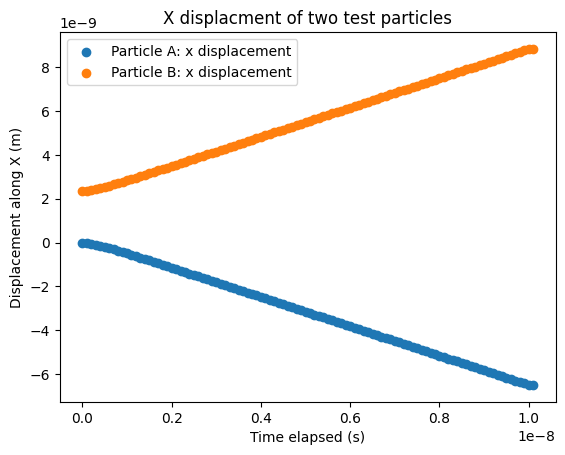

In [8]:
fig,ax = plt.subplots()
ax.scatter(simData['time'],particle_A_xpos)
ax.scatter(simData['time'],particle_B_xpos)
ax.legend(loc='upper left',labels=['Particle A: x displacement','Particle B: x displacement'])
ax.set_title('X displacment of two test particles')
ax.set_ylabel('Displacement along X (m)')
ax.set_xlabel('Time elapsed (s)')
ax.set_ylim()


In [ ]:
fig,ax = plt.subplots()
ax.scatter(simData['time'],particle_A_xvel)
ax.scatter(simData['time'],particle_B_xvel)
ax.legend(loc='center right',labels=['Particle A: x velocity','Particle B: x velocity'])
ax.set_title('X velocity of two test particles')
ax.set_ylabel('Velocity along X (m)')
ax.set_xlabel('Time elapsed (s)')
ax.set_ylim()

Velocity behaves as anticipated. The particles exhibit a sharp initial impulse when within the sigma order of magnitude of displacement.The impulse quickly becomes negligible after the simulated "collision" has passed. 
Lets take a loot at acceleration to make this clear

In [ ]:
fig,ax = plt.subplots()
ax.scatter(simData['time'],particle_A_xacc)
ax.scatter(simData['time'],particle_B_xacc)
ax.legend(loc='upper right',labels=['Particle A: x acceleration','Particle B: x acceleration'])
ax.set_title('X Acceleration of two test particles')
ax.set_ylabel('Acceleration along X (m)')
ax.set_xlabel('Time elapsed (s)')
ax.set_ylim()

<h4>Part 2 - particles in a box</h4>
Before we move on to more advanced simulations, it will be useful to demonstrate a collison with the container wall. Let's take a look at the behaviour over longer time as opposed to the short term collision time scale.

In [ ]:
sigma = 0.3345*10**-9 #m
particle_a = Particle()
# particle_b = Particle(position=vector.obj(x = 0.940669324510427*sigma,y=0.0,z=0.0))
particle_b = Particle(position=vector.obj(x = 9.4*sigma,y=0.0,z=0.0))
# print(particle_b.position.x)

particles=[particle_a,particle_b]
print(particles[0].position.x)
task_1_simulation = Simulation(10000*sigma,particles)
sim_length = 10000*sigma
state_list = task_1_simulation.main(delt=1e-8,nSteps=1000)

simData_1b = state_list

simData_1b = pd.DataFrame(simData_1b)
simData_1b.columns=('Particle A','Particle B')
simData_1b['time'] =  task_1_simulation.times
simData_1b['Particle A'][1].position.x
#Extracting the particle data 
particle_A_xpos = []
particle_A_xvel = []
particle_A_xacc = []

particle_B_xpos = []
particle_B_xvel = []
particle_B_xacc = []
for i in range(0,len(simData_1b['Particle A'])):
    xPos = simData_1b['Particle A'][i].position.x
    xVel = simData_1b['Particle A'][i].velocity.x
    xAcc = simData_1b['Particle A'][i].acceleration.x

    particle_A_xpos.append(xPos)
    particle_A_xvel.append(xVel)
    particle_A_xacc.append(xAcc)
    
    xPos = simData_1b['Particle B'][i].position.x
    xVel = simData_1b['Particle B'][i].velocity.x
    xAcc = simData_1b['Particle B'][i].acceleration.x
    
    particle_B_xpos.append(xPos)
    particle_B_xvel.append(xVel)
    particle_B_xacc.append(xAcc)
particle_B_xpos[0]/sigma





In [ ]:
fig,ax = plt.subplots()
ax.scatter(simData_1b['time'],particle_A_xpos)
print(particle_B_xpos[0]/sigma)

ax.scatter(simData_1b['time'],particle_B_xpos)
ax.legend(loc='upper left',labels=['Particle A: x displacement','Particle B: x displacement'])
ax.set_title('X displacment of two test particles')
ax.set_ylabel('Displacement along X (m)')
ax.set_xlabel('Time elapsed (s)')

# fig.savefig(fname='impossible_force_bug_example')




It appears that the two particles have exactly overlapped causing a huge impulse such that at each increment of the simulation

In [ ]:
fig,ax = plt.subplots()
ax.scatter(simData_1b['time'],particle_A_xacc)
ax.scatter(simData_1b['time'],particle_B_xacc)
ax.legend(loc='center right',labels=['Particle A: x displacement','Particle B: x displacement'])
ax.set_title('X acc of two test particles')
ax.set_ylabel('Displacement along X (m)')
ax.set_xlabel('Time elapsed (s)')

In [ ]:
fig,ax = plt.subplots()
ax.scatter(simData_1b['time'],particle_A_xvel)
ax.scatter(simData_1b['time'],particle_B_xvel)
ax.legend(loc='center right',labels=['Particle A: x displacement','Particle B: x displacement'])
ax.set_title('X velocity of two test particles')
ax.set_ylabel('Displacement along X (m/s)')
ax.set_xlabel('Time elapsed (s)')

In [ ]:
# particleB = Particle(position=vector.obj(x=2.1330553511270127e-09,y=0.0,z=0.0))
# particleA = Particle(position=vector.obj(x=1.6937157097293299e-09,y=0.0,z=0.0))
# particles=[particleA,particleB]
# print(particles[0].position.x)
# task_1_simulation_error = Simulation(10000*sigma,particles)
# state_list = task_1_simulation_error.main(delt=1e-9,nSteps=10000)

# simData_1c = state_list

# simData_1c = pd.DataFrame(simData_1c)
# simData_1c.columns=('Particle A','Particle B')
# simData_1c['time'] =  task_1_simulation.times
# simData_1c['Particle A'][1].position.x
# #Extracting the particle data 
# particle_A_xpos = []
# particle_A_xvel = []
# particle_A_xacc = []

# particle_B_xpos = []
# particle_B_xvel = []
# particle_B_xacc = []
# for i in range(0,len(simData_1c['Particle A'])):
#     xPos = simData_1c['Particle A'][i].position.x
#     xVel = simData_1c['Particle A'][i].velocity.x
#     xAcc = simData_1c['Particle A'][i].acceleration.x

#     particle_A_xpos.append(xPos)
#     particle_A_xvel.append(xVel)
#     particle_A_xacc.append(xAcc)
    
#     xPos = simData_1c['Particle B'][i].position.x
#     xVel = simData_1c['Particle B'][i].velocity.x
#     xAcc = simData_1c['Particle B'][i].acceleration.x
    
#     particle_B_xpos.append(xPos)
#     particle_B_xvel.append(xVel)
#     particle_B_xacc.append(xAcc)
# particle_B_xpos[0]/sigma




<h4>Broken initial condition, Overflow error?</h4>
Below I have found some initial conditions which break the code.
The velocity arbitrarily increases to a very high value, unexplainable by the acceleration.
I believe this to be an overflow error. 
On the main simulation this should be avoidable as dt timescales will be larger, the container will be larger as well, so we will not be concerned with the atomic scale nearly as much.


In [ ]:
# fig,ax = plt.subplots()
# ax.scatter(simData_1b['time'],particle_A_xpos)
# print(particle_B_xpos[0]/sigma)

# ax.scatter(simData_1b['time'],particle_B_xpos)
# ax.legend(loc='upper left',labels=['Particle A: x displacement','Particle B: x displacement'])
# ax.set_title('X displacment of two test particles')
# ax.set_ylabel('Displacement along X (m)')
# ax.set_xlabel('Time elapsed (s)')

# # fig.savefig(fname='impossible_force_bug_example')




In [ ]:
# fig,ax = plt.subplots()
# ax.scatter(simData_1b['time'],particle_A_xacc)
# ax.scatter(simData_1b['time'],particle_B_xacc)
# ax.legend(loc='center right',labels=['Particle A: x displacement','Particle B: x displacement'])
# ax.set_title('X acc of two test particles')
# ax.set_ylabel('Displacement along X (m)')
# ax.set_xlabel('Time elapsed (s)')
# ax.set_ylim(top=1e17,bottom=-1e16)

This plot confirms suspicion

In [ ]:
# accA = np.asarray(particle_B_xvel)
# print(np.max(particle_B_xvel))

In [ ]:
# fig,ax = plt.subplots()
# ax.scatter(simData_1b['time'],particle_A_xvel)
# ax.scatter(simData_1b['time'],particle_B_xvel)
# ax.legend(loc='center right',labels=['Particle A: x displacement','Particle B: x displacement'])
# ax.set_title('X velocity of two test particles')
# ax.set_ylabel('Displacement along X (m)')
# ax.set_xlabel('Time elapsed (s)')

In [ ]:
# delDistance = []
# for i in range(0,len(simData_1b['Particle B'])):
#     distance1 = simData_1b['Particle B'][i].position.x/sigma
#     distance2 = simData_1b['Particle A'][i].position.x/sigma
#     BrokenSigma = distance1-distance2
#     delDistance.append(BrokenSigma)

# fig,ax = plt.subplots()
# ax.plot(simData_1b['time'],delDistance)

<h4>Task 3 - Investigate</h4>
Of course we are primarily interested in numerical parameters, although there is merit in being able to see the behaviour of the particles.
Let's begin by using numpy to render the state of the simulation.


In [ ]:
#Converting particle data into 3 positional arrays
time = simData_1b['time']
state_list[0]
xCoords = []
yCoords = []
zCoords = []
particle_number = len(state_list[0])
for i in range(0,len(state_list)):
    currentXcoords = []
    currentYcoords = []
    currentZcoords = []
    for j in range (0,particle_number):
        currentXcoords.append(state_list[i][j].position.x)
        currentYcoords.append(state_list[i][j].position.y)
        currentZcoords.append(state_list[i][j].position.z)
    xCoords.append(currentXcoords)
    yCoords.append(currentYcoords)
    zCoords.append(currentZcoords)
    

In [ ]:
# print(xCoords)

In [ ]:
print(len(state_list))

In [ ]:

fig = plt.figure()
xlim = (-sim_length/2,sim_length/2)
ylim = (-sim_length/2,sim_length/2)
zlim = (-sim_length/2,sim_length/2)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1)    
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)


def update_points(num):
    num = num*10
    if (num <= len(xCoords)):
        graph._offsets3d = (xCoords[num],yCoords[num],zCoords[num])
    # print(xCoords[num])
    # ax.scatter(xs=xCoords[num],ys=yCoords[num],zs=zCoords[num])
    # return fig,ax
graph = ax.scatter(xs=xCoords[0],ys=yCoords[0],zs=zCoords[0])
anim = FuncAnimation(fig,update_points,frames=np.arange(0,200),repeat=False)
anim.save('test_gif.gif')


In [ ]:
print(xCoords)

In [ ]:
# fig,ax = plt.subplots()

# xplot = []
# for i in range(0,len(simData_1b)):
#     xplot.append(simData_1b['Particle A'][i].position.x)
# ax.scatter(simData_1b['time'],xplot)

Now that the evolution of the simulation has been successfully rendered, it is possible to proceed to higher particle simulations.
Goal here is to have the minimum density of such that the simulation behaves like a typical gas. 
Also a sensible number of particles should be chosen that simulation wall collisions occur frequently enough to have a relatively stable instantanious pressure.
These must also be be balanced by CPU and memory limitations.
I need the simulation to run in less than a minute for debugging purposes.

A decent compromise seems that we start with ~100 particles, each seperated by 3 sigma, with a box length of 11 sigma.

In [34]:
# Task 3 Simulation
sigma = 0.3345*10**-9 #m
#Let's begin by programatically setting intiial conditions.
task3_initial_state = []
particle_distance = 3.2*sigma
box_length = 10000*sigma
for i in range(-2,2):
    for j in range(-2,2):
        for k in range(-2,2):
            currentPosition = vector.obj(x=i*particle_distance,y=j*particle_distance,z=k*particle_distance)
            zero_vector = vector.obj(x=0.0,y=0.0,z=0.0)
            currentParticle = Particle(position=currentPosition,velocity=vector.obj(x=0.0,y=0.0,z=0.0),acceleration=vector.obj(x=0.0,y=0.0,z=0.0))
            task3_initial_state.append(currentParticle)

task_3_simulation = Simulation(length=box_length,initial_particle_state=task3_initial_state)
task_3_state_list = task_3_simulation.main(delt=1e-10,nSteps=1000)

sim_data_3 = pd.DataFrame(task_3_state_list)





Positions Used to get this acceleration
VectorObject3D(x=-634037479966.8605, y=-634037479966.8606, z=-634037479966.8606)
Positions Used to get this acceleration
VectorObject3D(x=-678272472973.0658, y=-678272472973.0658, z=-9693302363.05694)
Positions Used to get this acceleration
VectorObject3D(x=-678272472973.0659, y=-678272472973.0659, z=9693302363.056929)
Positions Used to get this acceleration
VectorObject3D(x=-634037479966.8607, y=-634037479966.8606, z=634037479966.8607)
Positions Used to get this acceleration
VectorObject3D(x=-678272472973.0659, y=-9693302363.057013, z=-678272472973.0659)
Positions Used to get this acceleration
VectorObject3D(x=-730063800101.2372, y=-12395759620.687187, z=-12395759620.687117)
Positions Used to get this acceleration
VectorObject3D(x=-730063800101.237, y=-12395759620.686958, z=12395759620.687103)
Positions Used to get this acceleration
VectorObject3D(x=-678272472973.0659, y=-9693302363.056936, z=678272472973.066)
Positions Used to get this accelera

In [35]:
#Extracting Coordinate information
sim_3_particle_number = 4*4*4

sim_3_xCoords = []
sim_3_yCoords = []
sim_3_zCoords = []
sim_3_temperatures = task_3_simulation.temperatures
sim_3_pressures = task_3_simulation.pressures
sim_3_average_pressure = task_3_simulation.calculate_average_pressure(1e-7)

for i in range(0,len(task_3_state_list)):
    currentXcoords = []
    currentYcoords = []
    currentZcoords = []
    for j in range (0,sim_3_particle_number):
        currentXcoords.append(task_3_state_list[i][j].position.x)
        currentYcoords.append(task_3_state_list[i][j].position.y)
        currentZcoords.append(task_3_state_list[i][j].position.z)
    sim_3_xCoords.append(currentXcoords)
    sim_3_yCoords.append(currentYcoords)
    sim_3_zCoords.append(currentZcoords)


In [ ]:
print(len(sim_3_xCoords[0]))

In [38]:
from mpl_toolkits.mplot3d import Axes3D
fig3 = plt.figure()
sim_3_xlim = (-box_length/2,box_length/2)
sim_3_ylim = (-box_length/2,box_length/2)
sim_3_zlim = (-box_length/2,box_length/2)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1)    
ax = fig3.add_subplot(111, projection='3d')
ax.set_xlim(sim_3_xlim)
ax.set_ylim(sim_3_ylim)
ax.set_zlim(sim_3_xlim)

graph = ax.scatter(xs=sim_3_xCoords[4],ys=sim_3_yCoords[4],zs=sim_3_zCoords[4])

def update_points(num):
    num = 10*num
    if (num <= len(sim_3_zCoords)):
        # print(len(sim_3_xCoords[0]))
        graph._offsets3d = (sim_3_xCoords[num],sim_3_yCoords[num],sim_3_zCoords[num])
    # print(xCoords[num])
    # ax.scatter(xs=xCoords[num],ys=yCoords[num],zs=zCoords[num])
    # return fig,ax
anim = FuncAnimation(fig3,update_points,frames=np.arange(0,len(sim_3_xCoords)),repeat=False)
anim.save('test_gif.gif')

In [ ]:
# print(sim_3_yCoords)